In [1]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM, NotearsLowRank

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

from dowhy import gcm
import pandas as pd

2024-04-29 18:45:11,328 - /home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


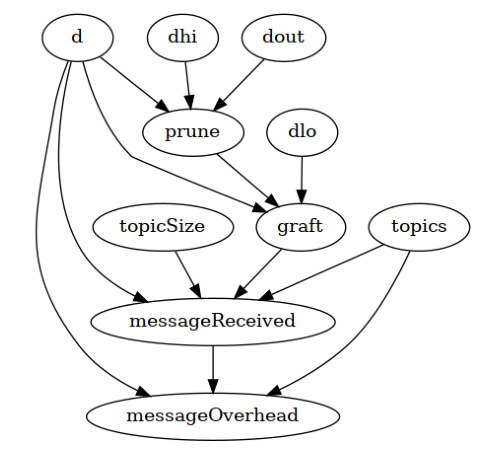

In [2]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dout', 'prune'),
                           # ('interval', 'graft'),
                           # ('interval', 'prune'),
                           ('prune', 'graft'),
                           ('messageReceived', 'messageOverhead'),
                           ('graft','messageReceived'),
                           ('topics', 'messageReceived'),
                           ('d', 'messageOverhead'),
                           ('topicSize', 'messageReceived'),
                           # ('topicSize','prune'),
                           ('topics', 'messageOverhead'),
                         ])


G=gcm.util.plot(causal_graph, figure_size=[6, 8])

In [3]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'messageOverhead', 'topics', 'topicSize']


In [7]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../../Datasets/Networkwise/consolidated_5s.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)


consolidated = consolidated.drop(columns=['experiment', 'topology'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
# consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
# consolidated.head(100)

consolidateddiff = consolidated.dropna().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'messageOverhead', 'topics', 'topicSize']]


# X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
# consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']]

#Rearrange columns according to nodes list
# nodes = causal_graph.nodes

# X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 'interval', 'messageOverhead']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(500)

,d,messageReceived,graft,prune,dlo,dhi,dout,messageOverhead,topics,topicSize
0,8,43.0,0.0,0.0,6,12,2,321.0,1,16
1,8,54.0,0.0,0.0,6,12,2,389.0,1,16
2,8,96.0,0.0,0.0,6,12,2,702.0,1,16
3,8,88.0,0.0,0.0,6,12,2,629.0,1,16
4,8,61.0,0.0,0.0,6,12,2,454.0,1,16
...,...,...,...,...,...,...,...,...,...,...
495,16,18.0,0.0,0.0,8,20,4,62.0,1,16
496,16,56.0,0.0,0.0,8,20,4,250.0,1,16
497,16,50.0,0.0,0.0,8,20,4,175.0,1,16
498,16,58.0,0.0,0.0,8,20,4,239.0,1,16


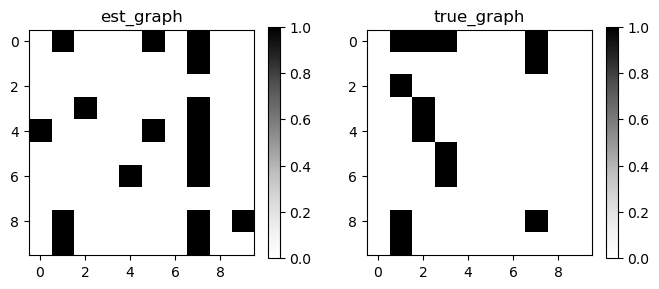

{'fdr': 0.5882, 'tpr': 0.5385, 'fpr': 0.3125, 'shd': 16, 'nnz': 17, 'precision': 0.4118, 'recall': 0.5385, 'F1': 0.4667, 'gscore': 0.0}


In [8]:
nt = Notears()
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, true_causal_matrix)

# calculate accuracy
met = MetricsDAG(nt.causal_matrix, true_causal_matrix)
print(met.metrics)

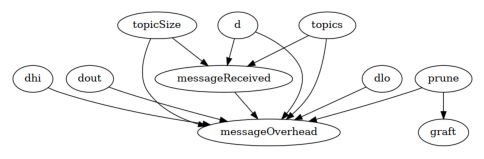

In [11]:
learned_causal_graph = nx.from_numpy_array(nt.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
            9:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

H.remove_edge('dout','dlo')
H.remove_edge('dlo','d')
H.remove_edge('dlo','dhi')
H.remove_edge('d','dhi')
H.remove_edge('topics','topicSize')

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[6, 8])

nx.write_adjlist(H, "./AdjLists/notears.adjlist")

A = nx.nx_agraph.to_agraph(H)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/notears.png")#, prog="dot")

# nx.draw(H, 'pc5s.png')

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [12]:
ntSob = NotearsNonlinear(model_type="sob")
ntSob.learn(X)

# plot est_dag and true_dag
GraphDAG(ntSob.causal_matrix, true_causal_matrix)

# calculate accuracy
met = MetricsDAG(ntSob.causal_matrix, true_causal_matrix)
print(met.metrics)

KeyboardInterrupt: 

In [ ]:
learned_causal_graph = nx.from_numpy_array(ntSob.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
            9:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# H.remove_edge('dout','dlo')

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[6, 8])

nx.write_adjlist(H, "./AdjLists/notearsSOB.adjlist")

A = nx.nx_agraph.to_agraph(H)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/notearsSOB.png")#, prog="dot")

# nx.draw(H, 'pc5s.png')

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [5]:
ntMLP = NotearsNonlinear(model_type="mlp")
ntMLP.learn(X)

# plot est_dag and true_dag
GraphDAG(ntMLP.causal_matrix, true_causal_matrix)

# calculate accuracy
met = MetricsDAG(ntMLP.causal_matrix, true_causal_matrix)
print(met.metrics)

KeyboardInterrupt: 

In [ ]:
learned_causal_graph = nx.from_numpy_array(ntMLP.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
            9:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# H.remove_edge('dout','dlo')

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[6, 8])

nx.write_adjlist(H, "./AdjLists/notearsMLP.adjlist")

A = nx.nx_agraph.to_agraph(H)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/notearsMLP.png")#, prog="dot")

# nx.draw(H, 'pc5s.png')

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

rank:  4


/home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/gradient/notears/low_rank.py:153: RuntimeWarning: overflow encountered in scalar multiply
  return loss + 0.5 * rho * h * h + alpha * h
/home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/gradient/notears/low_rank.py:172: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * 2 * \
/home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/gradient/notears/low_rank.py:184: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * 2 * \


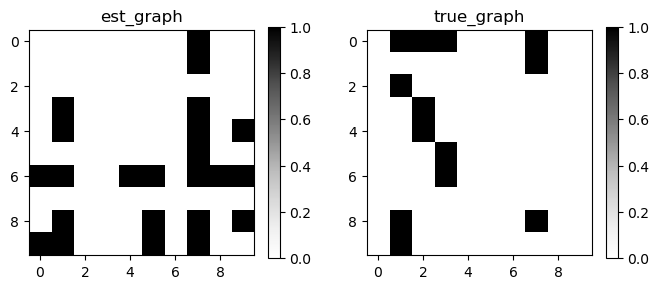

{'fdr': 0.7826, 'tpr': 0.3846, 'fpr': 0.5625, 'shd': 26, 'nnz': 23, 'precision': 0.2174, 'recall': 0.3846, 'F1': 0.2778, 'gscore': 0.0}


In [13]:
rank = np.linalg.matrix_rank(true_causal_matrix)
print('rank: ', rank)

# notears-low-rank learn
ntLowRank = NotearsLowRank()
ntLowRank.learn(X, rank=rank)

# plot est_dag and true_dag
GraphDAG(ntLowRank.causal_matrix, true_causal_matrix)

# calculate accuracy
met = MetricsDAG(ntLowRank.causal_matrix, true_causal_matrix)
print(met.metrics)

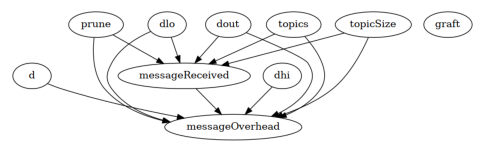

In [22]:
learned_causal_graph = nx.from_numpy_array(ntLowRank.causal_matrix, create_using=nx.DiGraph)
# learned_causal_graph = nx.read_adjlist("/home/flav/gossip/causalGossipSub/1_Discovery/MessageOverhead/AdjLists/notearsLowRank_old.adjlist", create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
            9:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# H.remove_edge('dlo','topics')
H.remove_edge('dlo','topicSize')
# H.remove_edge('dlo','dhi')
# H.remove_edge('dlo','d')
H.remove_edge('dout','topicSize')
H.remove_edge('dout','dlo')
# H.remove_edge('dout','d')
H.remove_edge('dout','topics')
H.remove_edge('dout','dhi')
H.remove_edge('dout','d')
H.remove_edge('topicSize','dhi')
H.remove_edge('topicSize','d')
H.remove_edge('topics','topicSize')
H.remove_edge('topics','dhi')
# H.remove_edge('dhi','topics')
# H.remove_edge('dhi','d')

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[6, 8])

nx.write_adjlist(H, "./AdjLists/notearsLowRank.adjlist")

A = nx.nx_agraph.to_agraph(H)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/notearsLowRank.png")#, prog="dot")

# nx.draw(H, 'pc5s.png')

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

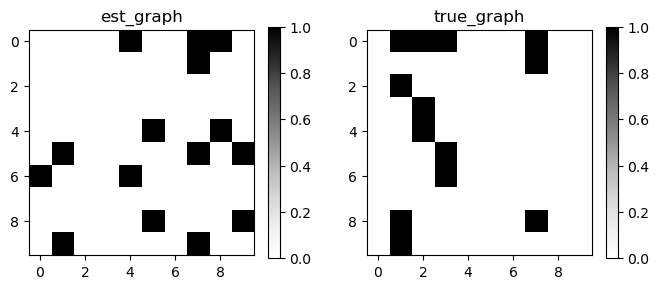

{'fdr': 0.8, 'tpr': 0.2308, 'fpr': 0.375, 'shd': 22, 'nnz': 15, 'precision': 0.2, 'recall': 0.2308, 'F1': 0.2143, 'gscore': 0.0}


In [24]:
# GOLEM learn
ntGolem = GOLEM(num_iter=1e4)
ntGolem.learn(X)

# plot est_dag and true_dag
GraphDAG(ntGolem.causal_matrix, true_causal_matrix)

# calculate accuracy
met = MetricsDAG(ntGolem.causal_matrix, true_causal_matrix)
print(met.metrics)

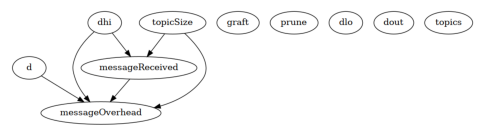

In [27]:
learned_causal_graph = nx.from_numpy_array(ntGolem.causal_matrix, create_using=nx.DiGraph)
# learned_causal_graph = nx.read_adjlist("/home/flav/gossip/causalGossipSub/1_Discovery/MessageOverhead/AdjLists/notearsGolem_old.adjlist", create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
            9:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

H.remove_edge('dout','d')
H.remove_edge('dout','dlo')
# H.remove_edge('topicSize','dout')
# H.remove_edge('topicSize','dlo')
# H.remove_edge('topicSize','topics')
H.remove_edge('dlo','dhi')
H.remove_edge('dlo','topics')
H.remove_edge('topics','dhi')
H.remove_edge('topics','topicSize')
H.remove_edge('d','dlo')
H.remove_edge('d','topics')
H.remove_edge('dhi','topicSize')

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[6, 8])

nx.write_adjlist(H, "./AdjLists/notearsGolem.adjlist")

A = nx.nx_agraph.to_agraph(H)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/notearsGolem.png")#, prog="dot")

# nx.draw(H, 'pc5s.png')

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab